# FIKH Model: Steady-State Flow Curves

## What is FIKH?

The **Fractional Isotropic-Kinematic Hardening (FIKH)** model extends classical thixotropic-elastoviscoplastic (TEvP) constitutive models by replacing ordinary time derivatives with **Caputo fractional derivatives**. This innovation captures **power-law memory effects** observed in complex fluids with hierarchical microstructure.

### Physical Foundation

FIKH combines three key ingredients:

1. **Fractional viscoelasticity**: Power-law stress relaxation $G(t) \sim t^{-\alpha}$ via Caputo derivative $D_t^{\alpha}$ (order $0 < \alpha < 1$)
2. **Kinematic hardening**: Armstrong-Frederick backstress evolution for directional memory (Bauschinger effect)
3. **Thixotropic structure**: Microstructural parameter $\lambda \in [0,1]$ governs yield stress evolution

**Key physics**: The fractional derivative $D_t^{\alpha} \lambda$ introduces a **fading memory kernel** $K(t) \sim t^{-\alpha}$ where recent deformation history affects current structure more than distant past. This captures stretched exponential recovery and broad relaxation spectra without requiring multiple exponential modes.

### When to Use FIKH

FIKH is appropriate for materials exhibiting:

- **Power-law stress relaxation** at long times (not pure exponential)
- **Stretched exponential recovery** after shear cessation
- **Delayed yielding** in creep tests (viscosity bifurcation)
- **Broad relaxation spectra** in frequency sweeps (Cole-Cole depression)
- **Aging effects** with non-Markovian kinetics

**Typical materials**: Waxy crude oils, colloidal gels, drilling fluids, food gels, greases with hierarchical structure.

> **Handbook:** See [FIKH documentation](../../docs/source/models/fikh/fikh.rst) for detailed theoretical background covering Caputo derivatives, Mittag-Leffler relaxation, and thermokinematic coupling.

## Learning Objectives

1. Fit the **FIKH** model to steady-state flow curve data
2. Understand the **Caputo fractional derivative** and its physical interpretation
3. Explore the effect of **$\alpha$ (fractional order)** on structure recovery dynamics
4. Compare FIKH behavior across different $\alpha$ values (0.3 to 0.99)
5. Use NLSQ warm-start for efficient Bayesian inference with NUTS
6. Calibrate parameters for downstream synthetic data generation (NB03, NB05)

## Prerequisites

- Basic RheoJAX usage (basic/01_quick_start.ipynb)
- Bayesian inference fundamentals (bayesian/01_bayesian_basics.ipynb)
- Recommended: IKH tutorials (ikh/01_mikh_flow_curve.ipynb) for comparison with $\alpha = 1$ limit

**Estimated Time:** 3-5 minutes (fast demo), 15-20 minutes (full run)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

# Add examples/utils to path for tutorial utilities
# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    compute_fikh_structure_evolution,
    compute_fikh_yield_stress,
    compute_fit_quality,
    get_fikh_param_names,
    load_ml_ikh_flow_curve,
    plot_alpha_sweep,
    plot_structure_recovery,
    print_alpha_interpretation,
    print_convergence_summary,
    print_parameter_comparison,
    save_fikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

# FAST_MODE: controlled by environment variable
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

jax, jnp = safe_import_jax()
verify_float64()

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: FIKH Model

The **Fractional Isotropic-Kinematic Hardening (FIKH)** model extends classical IKH by replacing the ordinary time derivative in structure evolution with a **Caputo fractional derivative**. This introduces power-law memory effects.

### Key Innovation: Fractional Structure Evolution

**Classical IKH** (exponential memory):
$$
\frac{d\lambda}{dt} = \frac{1-\lambda}{\tau_{thix}} - \Gamma \lambda |\dot{\gamma}^p|
$$

**FIKH** (power-law memory via Caputo derivative):
$$
D^\alpha_C \lambda = \frac{1-\lambda}{\tau_{thix}} - \Gamma \lambda |\dot{\gamma}^p|
$$

where $D^\alpha_C$ is the Caputo fractional derivative of order $\alpha \in (0, 1)$:
$$
D^\alpha_C f(t) = \frac{1}{\Gamma(1-\alpha)} \int_0^t \frac{f'(\tau)}{(t-\tau)^\alpha} d\tau
$$

### Physical Interpretation of $\alpha$

| $\alpha$ Range | Memory Type | Physical Meaning |
|----------------|-------------|------------------|
| $\alpha \to 0$ | Very strong | Extremely slow recovery, long-term memory |
| $0.3 - 0.5$ | Strong | Power-law dominated, slow thixotropic rebuilding |
| $0.5 - 0.7$ | Moderate | Balanced power-law and exponential character |
| $0.7 - 0.9$ | Weak | Approaching classical behavior |
| $\alpha \to 1$ | None | **Recovers classical IKH** (exponential) |

### Parameters (12 isothermal)

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| **G** | $G$ | Shear modulus (Pa) | 10 - 10000 Pa |
| **eta** | $\eta$ | Maxwell viscosity (Pa·s) | 10 - 10^8 Pa·s |
| **C** | $C$ | Kinematic hardening modulus (Pa) | 10 - 500 Pa |
| **gamma_dyn** | $\gamma_{dyn}$ | Dynamic recovery strain | 0.01 - 10 |
| **m** | $m$ | AF recovery exponent | 0.5 - 2 |
| **sigma_y0** | $\sigma_{y0}$ | Minimal yield stress (Pa) | 1 - 100 Pa |
| **delta_sigma_y** | $\Delta\sigma_y$ | Structural yield contribution (Pa) | 0 - 100 Pa |
| **tau_thix** | $\tau_{thix}$ | Thixotropic rebuilding time (s) | 1 - 1000 s |
| **Gamma** | $\Gamma$ | Structure breakdown coefficient | 0.001 - 10 |
| **alpha_structure** | $\alpha$ | **Fractional order (0 < α < 1)** | 0.3 - 0.99 |
| **eta_inf** | $\eta_{\infty}$ | High-shear viscosity (Pa·s) | 0.01 - 10 Pa·s |
| **mu_p** | $\mu_p$ | Plastic viscosity (Pa·s) | 10^-6 - 1 Pa·s |

### Memory Kernel

The Caputo derivative uses a power-law memory kernel:
$$
K(t) = \frac{t^{-\alpha}}{\Gamma(1-\alpha)}
$$

- **Classical IKH ($\alpha=1$)**: $K(t) = \delta(t)$ (instantaneous)
- **FIKH ($\alpha<1$)**: $K(t) \sim t^{-\alpha}$ (power-law decay)

This means the structure "remembers" its history with a slowly decaying weight.

## 3. Load Data

We use the same ML-IKH experimental data as the classical IKH tutorials (Wei et al. 2018, J. Rheol). This allows direct comparison between FIKH and classical IKH fits.

In [3]:
# Load ARES rate sweep up data
gamma_dot, stress = load_ml_ikh_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


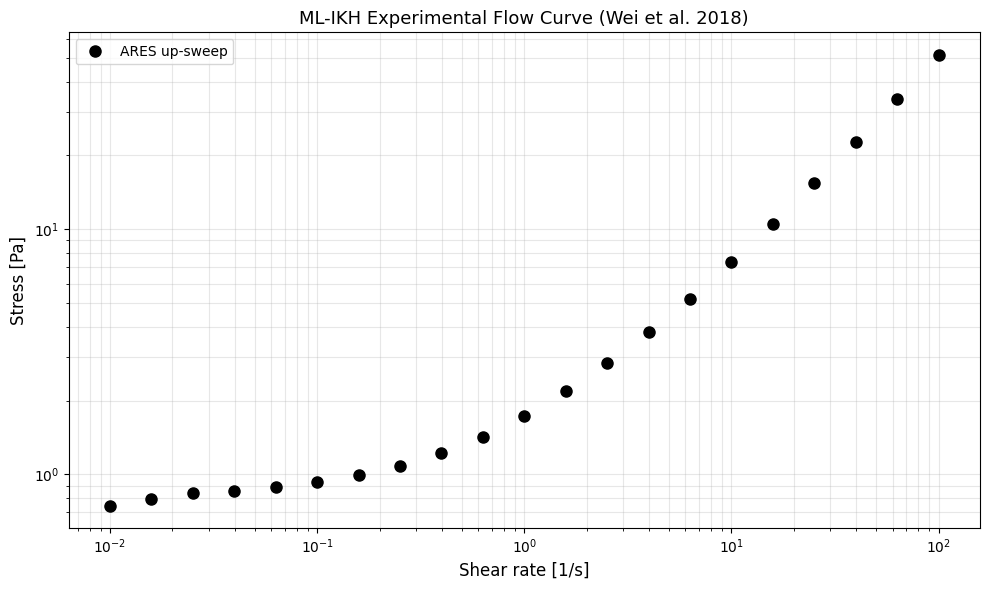

In [4]:
# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=8, label="ARES up-sweep")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("ML-IKH Experimental Flow Curve (Wei et al. 2018)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Initial Fit

We fit the FIKH model with a moderate fractional order ($\alpha = 0.7$) as starting point.

In [5]:
# Create FIKH model (isothermal, fractional order 0.7)
model = FIKH(include_thermal=False, alpha_structure=0.7)

t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

# Get parameter names (isothermal)
param_names = get_fikh_param_names(include_thermal=False)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=12 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.521940s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=4.1340 | elapsed=1.522s | final_gradient_norm=1.1439e-06


NLSQ fit time: 1.73 s

Fitted parameters:
  G               = 1000
  eta             = 1.527e+06
  C               = 2.11e+04
  gamma_dyn       = 2.96
  m               = 0.5093
  sigma_y0        = 1.328
  delta_sigma_y   = 0.03586
  tau_thix        = 3.777e+07
  Gamma           = 3125
  alpha_structure = 0.7
  eta_inf         = 0.5119
  mu_p            = 0.001036


In [6]:
# Compute fit quality
stress_pred = model.predict(gamma_dot, test_mode="flow_curve")
metrics = compute_fit_quality(stress, stress_pred)

# Fine grid for alpha sweep and decomposition plots
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    200,
)
stress_pred_fine = model.predict(gamma_dot_fine, test_mode="flow_curve")

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R^2:   0.997611
  RMSE:  0.6275 Pa
  NRMSE: 1.2374%


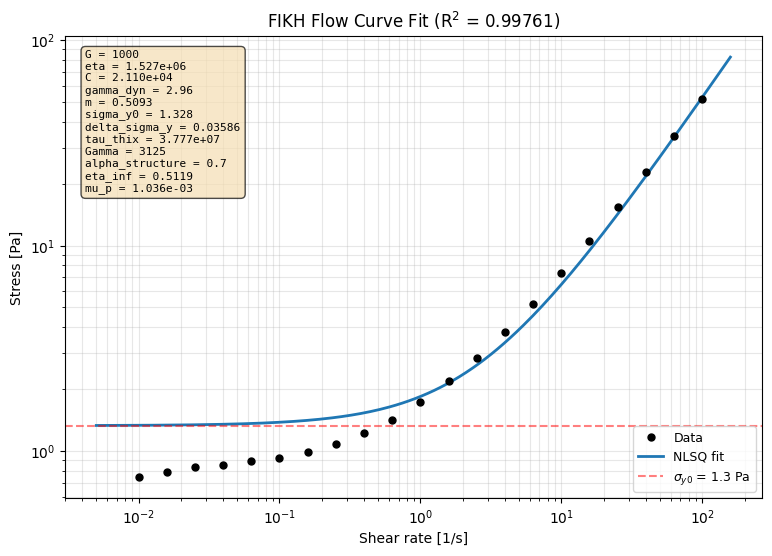

In [7]:
# Plot NLSQ fit with uncertainty band
fig, ax = plot_nlsq_fit(
    gamma_dot, stress, model, test_mode="flow_curve",
    param_names=param_names, log_scale=True,
    xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
    title=f"FIKH Flow Curve Fit (R$^2$ = {metrics['R2']:.5f})",
)

# Add yield stress reference
sigma_y0 = model.parameters.get_value("sigma_y0")
ax.axhline(sigma_y0, color="red", linestyle="--", alpha=0.5,
           label=f"$\\sigma_{{y0}}$ = {sigma_y0:.1f} Pa")
ax.legend(fontsize=9)

display(fig)
plt.close(fig)

## 5. Alpha Exploration

This is the **key differentiator** of FIKH from classical IKH. We explore how the fractional order $\alpha$ affects:
1. Flow curve predictions
2. Memory kernel decay
3. Structure recovery dynamics

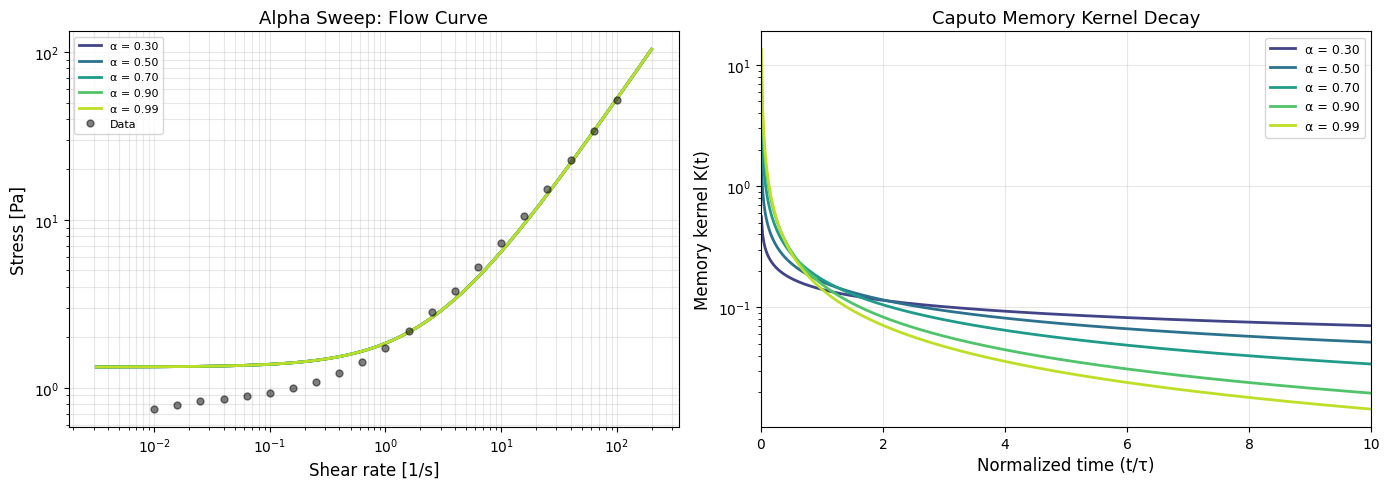

In [8]:
# Alpha sweep: Compare predictions across different fractional orders
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]

fig = plot_alpha_sweep(
    model,
    protocol="flow_curve",
    alpha_values=alpha_values,
    x_data=gamma_dot_fine,
    figsize=(14, 5),
)

# Add data points to left panel
fig.axes[0].loglog(gamma_dot, stress, "ko", markersize=5, alpha=0.5, label="Data")
fig.axes[0].legend(fontsize=8, loc="best")

display(fig)
plt.close(fig)

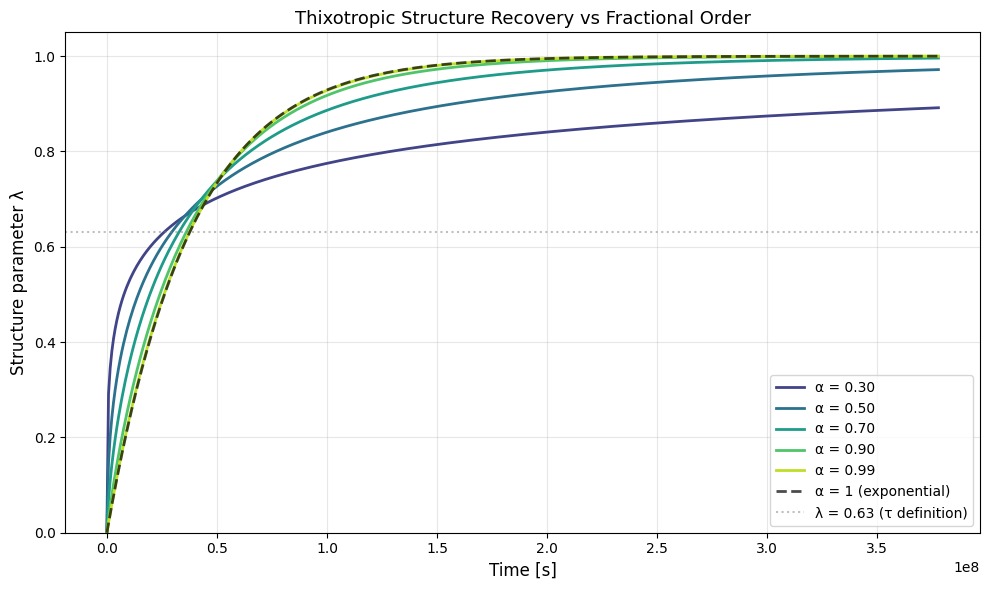

In [9]:
# Structure recovery: Show how alpha affects thixotropic rebuilding
tau_thix = model.parameters.get_value("tau_thix")

fig = plot_structure_recovery(
    alpha_values=alpha_values,
    tau_thix=tau_thix,
    t_max=10 * tau_thix,
    figsize=(10, 6),
)
display(fig)
plt.close(fig)

In [10]:
# Physical interpretation of fitted alpha
fitted_alpha = model.parameters.get_value("alpha_structure")
print_alpha_interpretation(fitted_alpha)

Fractional Order Interpretation: α = 0.700

Regime: Weak Memory

Approaching classical behavior with mild power-law tails.
Recovery is mostly exponential with slow corrections.
Suitable for: Mildly thixotropic materials.

Physical Implications:
  • Memory kernel decay: t^(-0.70)
  • Recovery time scale: > τ_thix × Γ(1+0.70) = 0.91 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.70


### 5.1 Physical Analysis

Let's decompose the flow curve into its contributing mechanisms.

In [11]:
# Extract key physical parameters
sigma_y0 = model.parameters.get_value("sigma_y0")
delta_sigma_y = model.parameters.get_value("delta_sigma_y")
eta_inf = model.parameters.get_value("eta_inf")
tau_thix = model.parameters.get_value("tau_thix")
Gamma = model.parameters.get_value("Gamma")
alpha = model.parameters.get_value("alpha_structure")

print("Physical Analysis:")
print("=" * 55)
print(f"Fractional order:                    {alpha:.3f}")
print(f"Minimal yield stress (destructured): {sigma_y0:.2f} Pa")
print(f"Maximum yield stress (structured):   {sigma_y0 + delta_sigma_y:.2f} Pa")
print(f"Yield stress range:                  {delta_sigma_y:.2f} Pa")
print(f"High-shear viscosity:                {eta_inf:.4g} Pa.s")
print(f"Thixotropic rebuilding time:         {tau_thix:.2g} s")
print(f"Breakdown coefficient:               {Gamma:.4g}")

Physical Analysis:
Fractional order:                    0.700
Minimal yield stress (destructured): 1.33 Pa
Maximum yield stress (structured):   1.36 Pa
Yield stress range:                  0.04 Pa
High-shear viscosity:                0.5119 Pa.s
Thixotropic rebuilding time:         3.8e+07 s
Breakdown coefficient:               3125


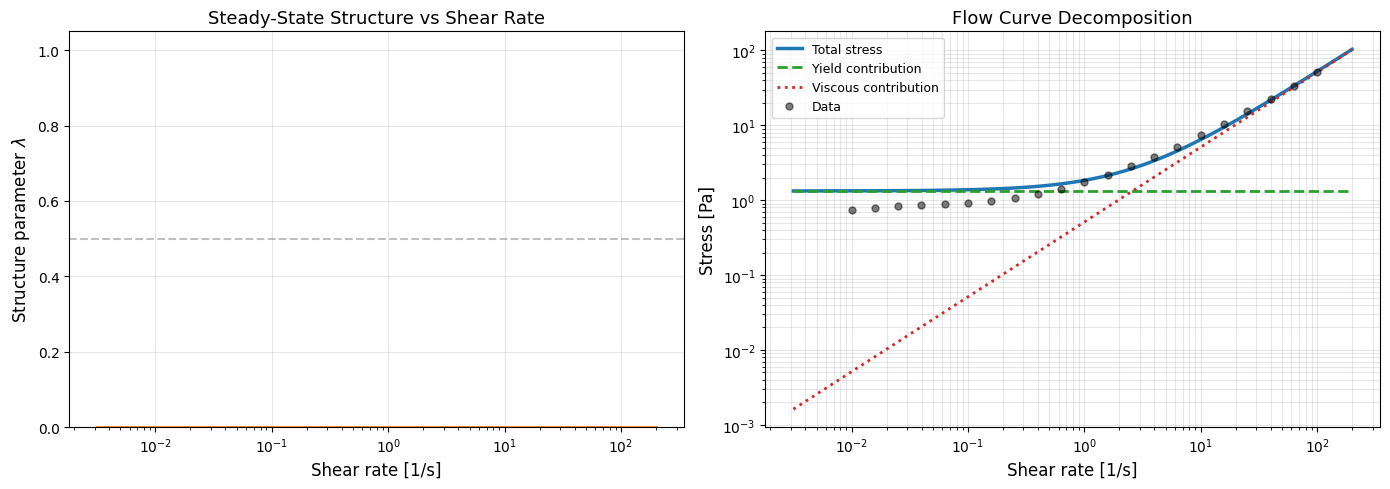

In [12]:
# Decompose flow curve into contributions
# Note: Steady-state structure is independent of alpha
lambda_ss = compute_fikh_structure_evolution(gamma_dot_fine, tau_thix, Gamma, alpha)
sigma_y_ss = compute_fikh_yield_stress(lambda_ss, sigma_y0, delta_sigma_y)

# Viscous contribution
sigma_viscous = eta_inf * gamma_dot_fine

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Structure evolution
ax1.semilogx(gamma_dot_fine, lambda_ss, lw=2, color="C1")
ax1.set_xlabel("Shear rate [1/s]", fontsize=12)
ax1.set_ylabel("Structure parameter $\\lambda$", fontsize=12)
ax1.set_title("Steady-State Structure vs Shear Rate", fontsize=13)
ax1.set_ylim(0, 1.05)
ax1.axhline(0.5, color="gray", linestyle="--", alpha=0.5)
ax1.grid(True, alpha=0.3)

# Right: Stress decomposition
ax2.loglog(gamma_dot_fine, stress_pred_fine, lw=2.5, color="C0", label="Total stress")
ax2.loglog(gamma_dot_fine, sigma_y_ss, "--", lw=2, color="C2", label="Yield contribution")
ax2.loglog(gamma_dot_fine, sigma_viscous, ":", lw=2, color="C3", label="Viscous contribution")
ax2.loglog(gamma_dot, stress, "ko", markersize=5, alpha=0.5, label="Data")

ax2.set_xlabel("Shear rate [1/s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Flow Curve Decomposition", fontsize=13)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference with NUTS

### 6.1 Run NUTS

We use the NLSQ point estimates as warm-start values. The fractional order $\alpha$ is also inferred from data.

In [13]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for name, val in initial_values.items():
    print(f"  {name:15s} = {val:.4g}")

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

print(f"\nRunning NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  G               = 1000
  eta             = 1.527e+06
  C               = 2.11e+04
  gamma_dyn       = 2.96
  m               = 0.5093
  sigma_y0        = 1.328
  delta_sigma_y   = 0.03586
  tau_thix        = 3.777e+07
  Gamma           = 3125
  alpha_structure = 0.7
  eta_inf         = 0.5119
  mu_p            = 0.001036

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<11:05,  1.05it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   4%|▍         | 27/700 [00:01<00:19, 34.60it/s, 255 steps of size 4.78e-03. acc. prob=0.80]

warmup:   7%|▋         | 50/700 [00:01<00:10, 64.91it/s, 255 steps of size 8.39e-03. acc. prob=0.84]

warmup:  11%|█         | 74/700 [00:01<00:06, 96.41it/s, 255 steps of size 1.12e-02. acc. prob=0.86]

warmup:  14%|█▍        | 98/700 [00:01<00:04, 125.23it/s, 255 steps of size 1.88e-02. acc. prob=0.87]

warmup:  18%|█▊        | 126/700 [00:01<00:03, 159.20it/s, 255 steps of size 1.32e-02. acc. prob=0.86]

warmup:  22%|██▏       | 155/700 [00:01<00:02, 189.69it/s, 255 steps of size 6.88e-03. acc. prob=0.86]

warmup:  26%|██▌       | 180/700 [00:01<00:02, 203.75it/s, 255 steps of size 3.38e-03. acc. prob=0.87]

sample:  29%|██▉       | 205/700 [00:01<00:02, 207.67it/s, 255 steps of size 8.40e-03. acc. prob=0.98]

sample:  33%|███▎      | 229/700 [00:01<00:02, 214.90it/s, 255 steps of size 8.40e-03. acc. prob=0.96]

sample:  36%|███▌      | 253/700 [00:01<00:02, 220.70it/s, 255 steps of size 8.40e-03. acc. prob=0.96]

sample:  40%|███▉      | 277/700 [00:02<00:01, 222.94it/s, 255 steps of size 8.40e-03. acc. prob=0.97]

sample:  43%|████▎     | 301/700 [00:02<00:01, 223.54it/s, 255 steps of size 8.40e-03. acc. prob=0.96]

sample:  46%|████▋     | 325/700 [00:02<00:01, 221.27it/s, 255 steps of size 8.40e-03. acc. prob=0.96]

sample:  50%|████▉     | 349/700 [00:02<00:01, 224.65it/s, 255 steps of size 8.40e-03. acc. prob=0.96]

sample:  53%|█████▎    | 373/700 [00:02<00:01, 227.42it/s, 255 steps of size 8.40e-03. acc. prob=0.96]

sample:  57%|█████▋    | 397/700 [00:02<00:01, 227.24it/s, 255 steps of size 8.40e-03. acc. prob=0.95]

sample:  60%|██████    | 420/700 [00:02<00:01, 227.88it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  63%|██████▎   | 444/700 [00:02<00:01, 229.01it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  67%|██████▋   | 468/700 [00:02<00:01, 231.95it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  70%|███████   | 492/700 [00:03<00:00, 231.60it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  74%|███████▍  | 517/700 [00:03<00:00, 233.79it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  77%|███████▋  | 541/700 [00:03<00:00, 234.03it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  81%|████████  | 565/700 [00:03<00:00, 234.57it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  84%|████████▍ | 589/700 [00:03<00:00, 235.07it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  88%|████████▊ | 613/700 [00:03<00:00, 233.84it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  91%|█████████ | 637/700 [00:03<00:00, 227.54it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  94%|█████████▍| 660/700 [00:03<00:00, 223.32it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample:  98%|█████████▊| 685/700 [00:03<00:00, 228.08it/s, 255 steps of size 8.40e-03. acc. prob=0.94]

sample: 100%|██████████| 700/700 [00:03<00:00, 177.59it/s, 255 steps of size 8.40e-03. acc. prob=0.94]


Bayesian inference time: 6.0 s


### 6.2 Convergence Diagnostics

Check R-hat (target < 1.05) and effective sample size (ESS, target > 100 for demo).

**Diagnostic Interpretation:**

| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain convergence (< 1.05 acceptable) |
| **ESS** | > 400 | Effective sample size (> 100 minimum) |
| **Divergences** | < 1% | NUTS sampling quality |

In [14]:
# Convergence diagnostics table
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    0.9980       142      PASS
            eta    0.9980       388      PASS
              C    0.9999       105      PASS
      gamma_dyn    0.9981       252      PASS
              m    0.9987       137      PASS
       sigma_y0    1.0253       128      PASS
  delta_sigma_y    1.0016       177      PASS
       tau_thix    1.0274        99     CHECK
          Gamma    1.0020        75     CHECK
alpha_structure    0.9985       161      PASS
        eta_inf    0.9999        33     CHECK
           mu_p    1.0001        33     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


### 6.3 ArviZ Diagnostic Plots

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


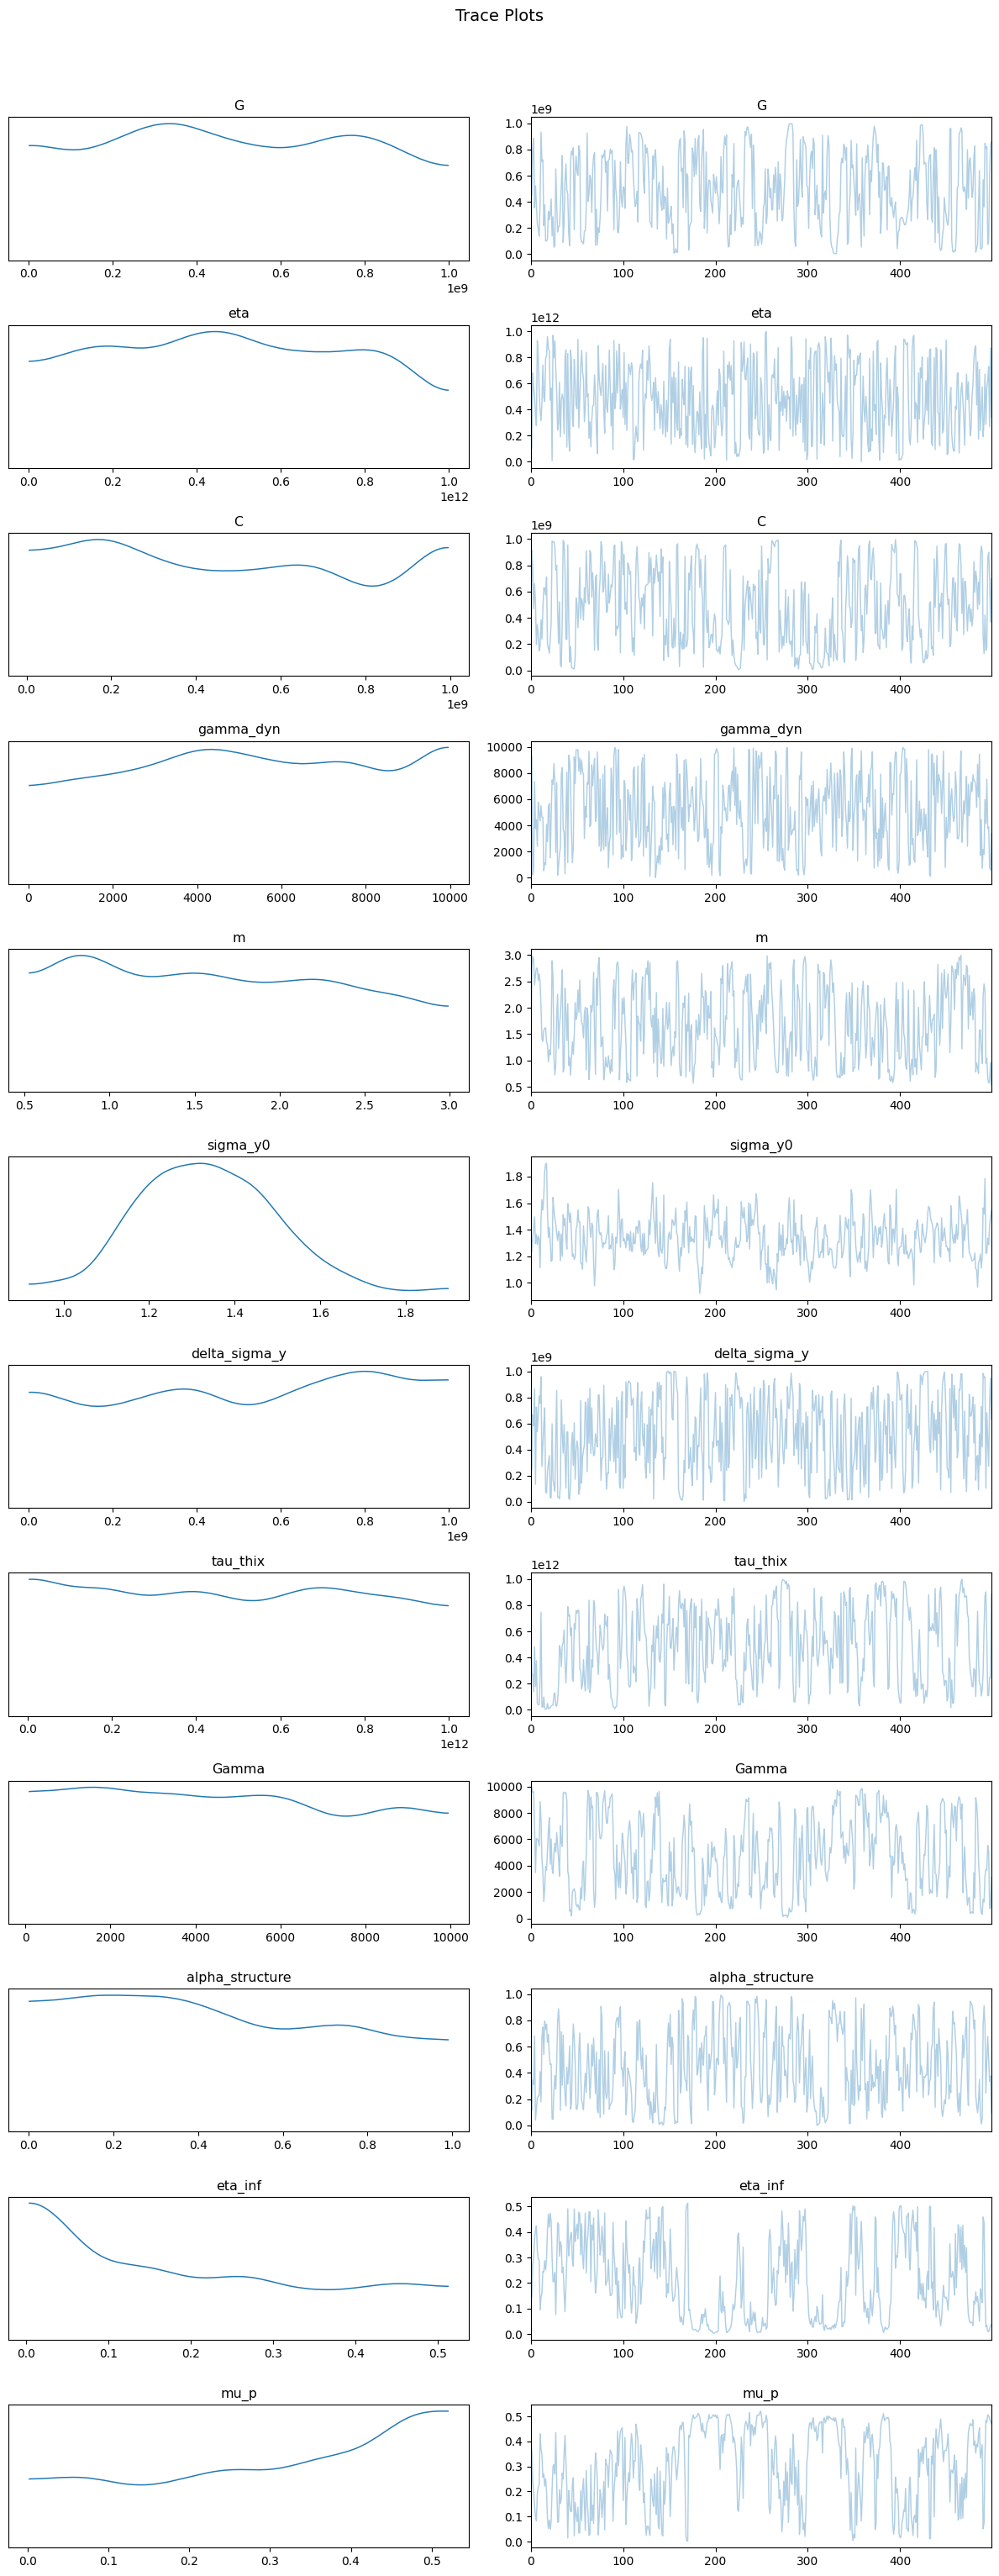

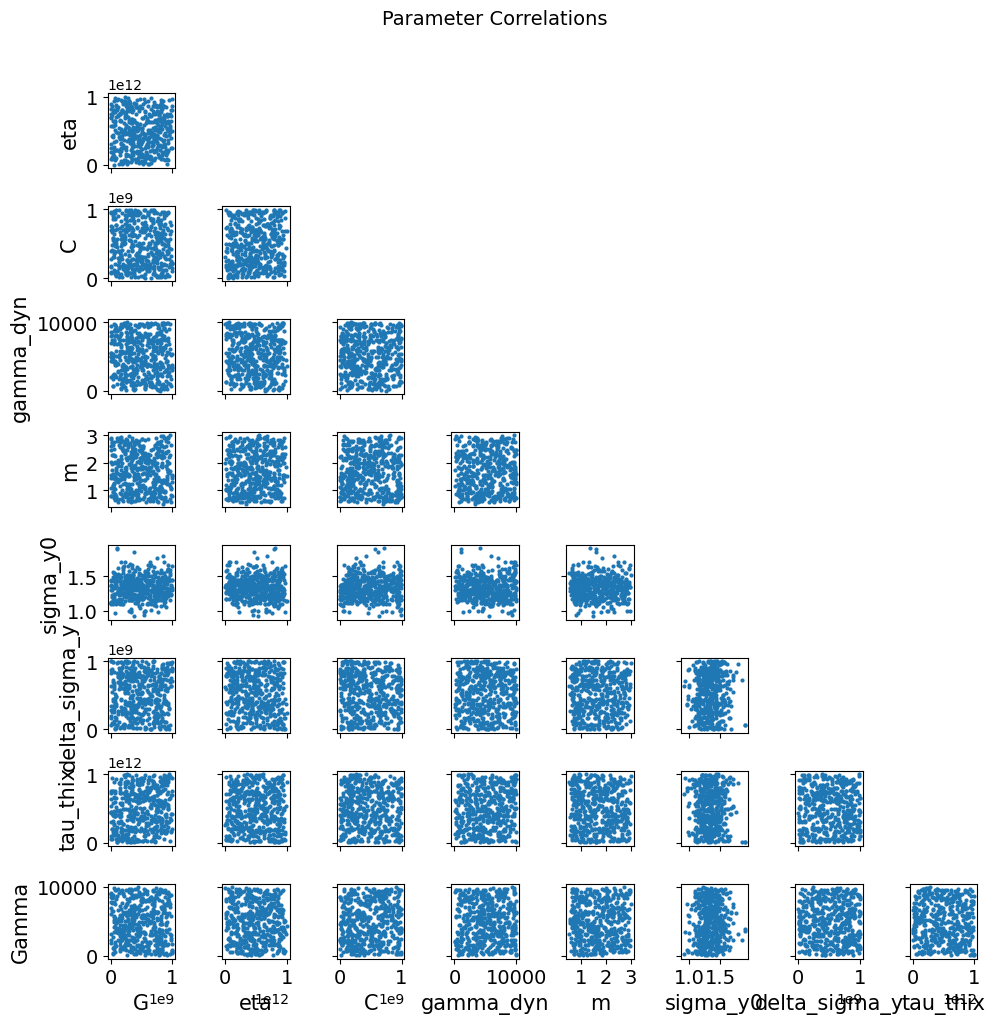

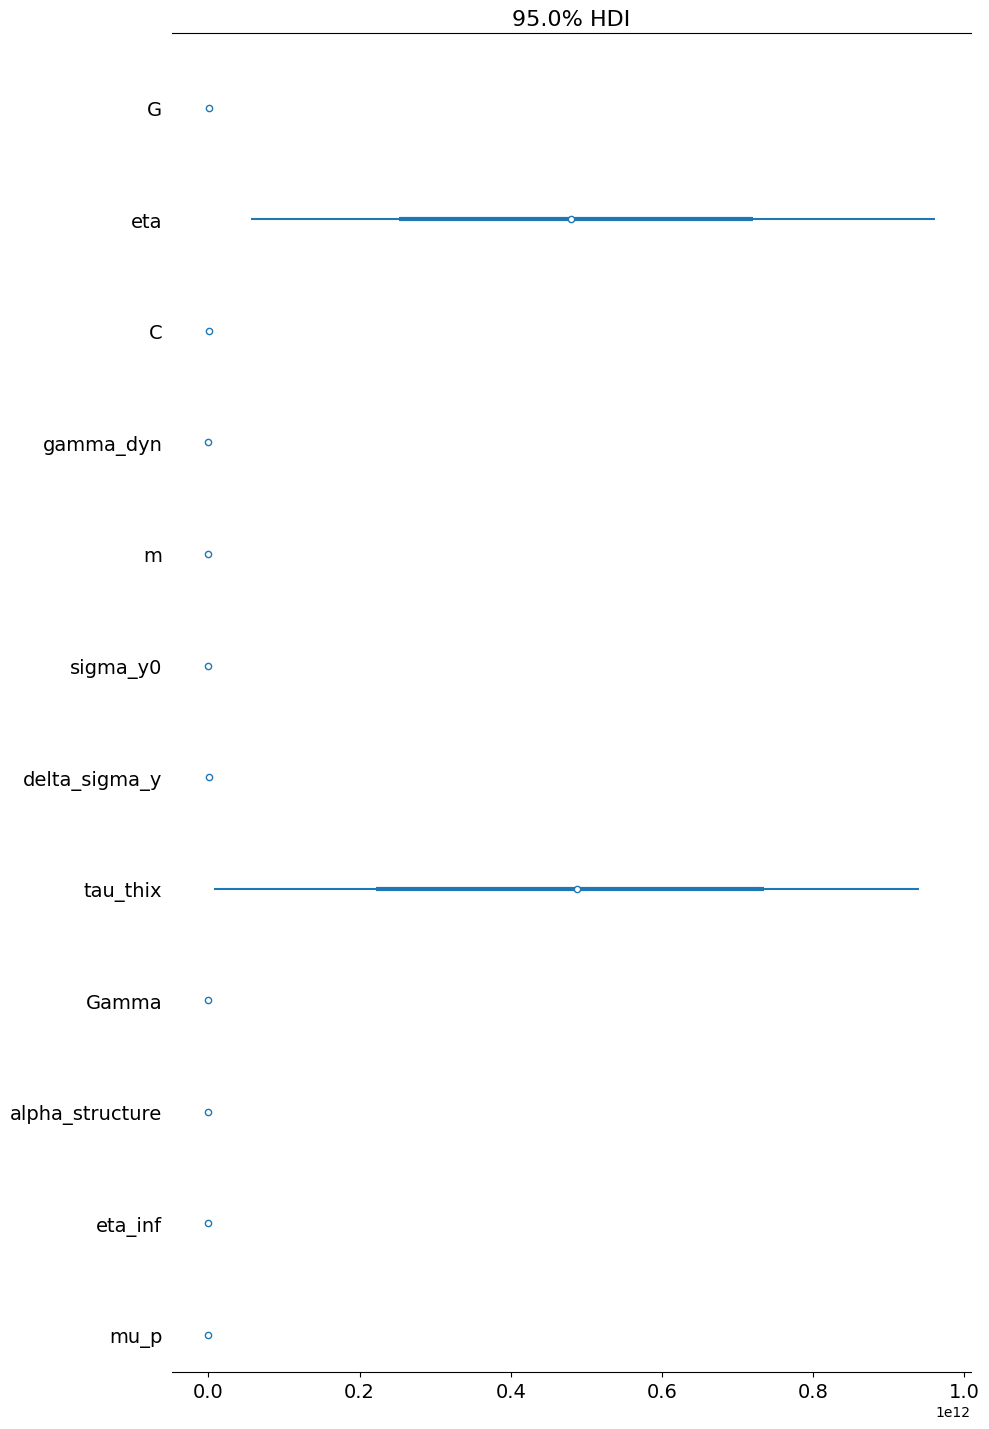

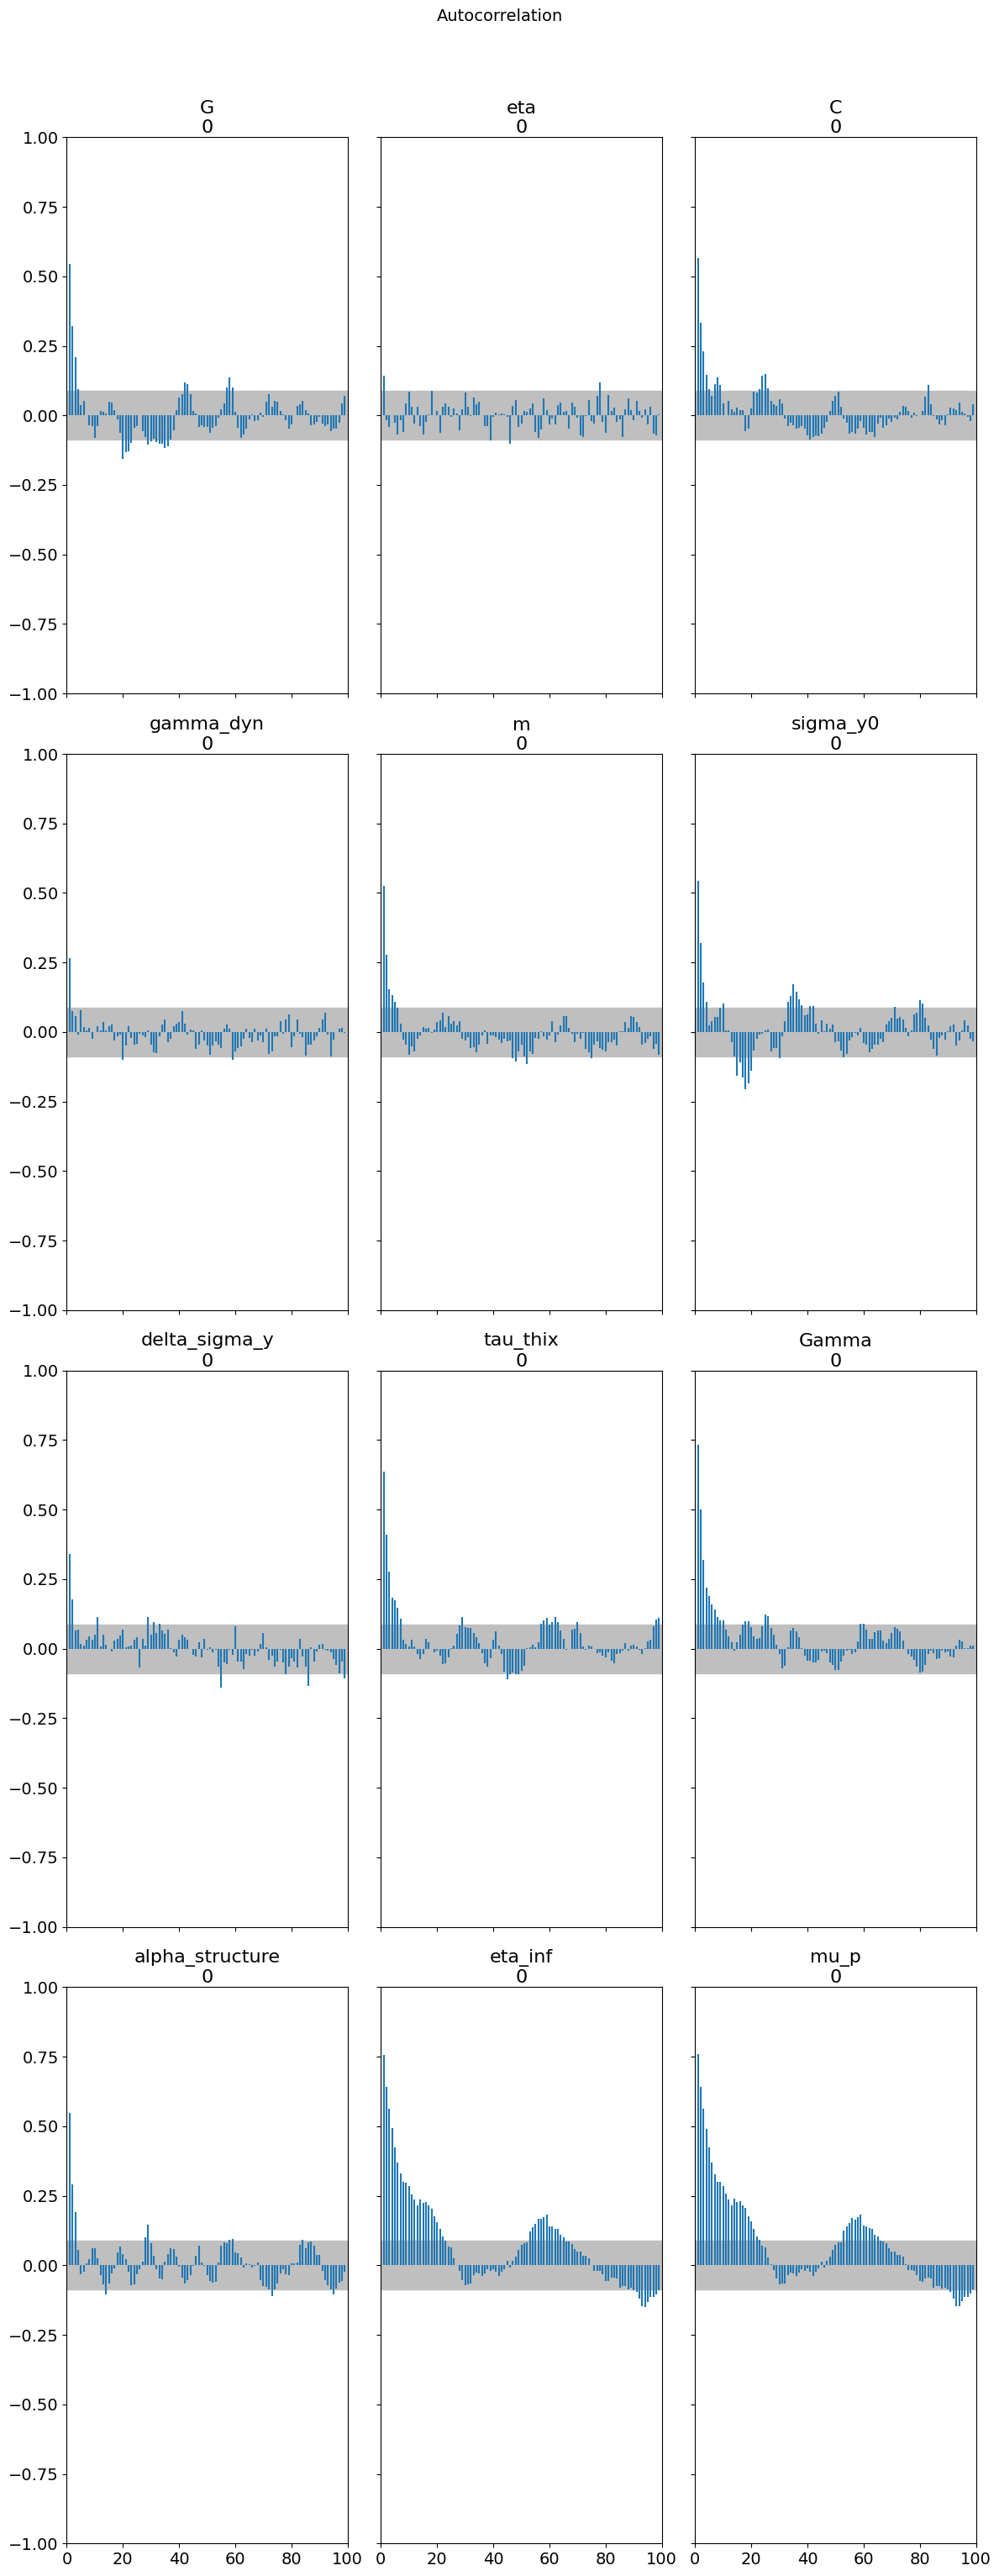

In [15]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 6.4 Posterior Predictive Check

Validate the model by comparing data against predictions from posterior samples.

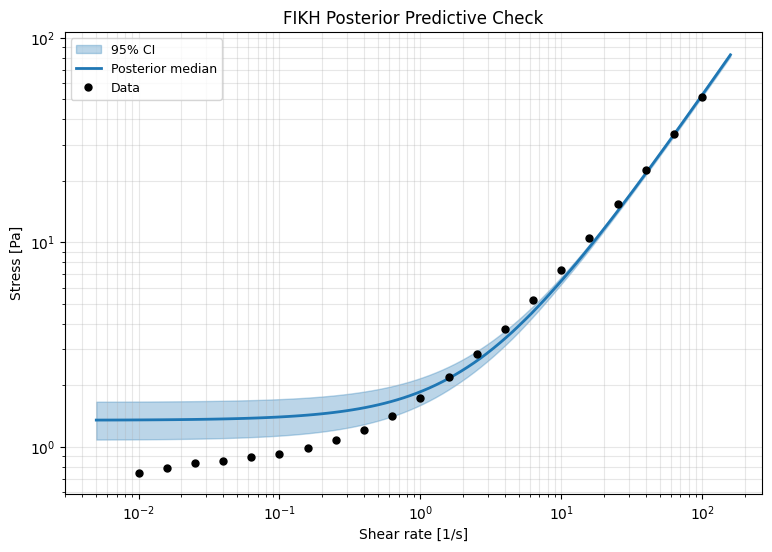

In [16]:
# Posterior predictive with 95% credible intervals
fig, ax = plot_posterior_predictive(
    gamma_dot, stress, model, result,
    test_mode="flow_curve", param_names=param_names,
    log_scale=True,
    xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
    title="FIKH Posterior Predictive Check",
)
display(fig)
plt.close(fig)

### 6.5 Parameter Summary

Compare NLSQ point estimates with Bayesian posterior.

In [17]:
# NLSQ vs Bayesian comparison table
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G     5.495e+08     4.773e+08  [2.72e+07, 9.642e+08]
            eta     1.068e+11     4.792e+11  [2.975e+10, 9.427e+11]
              C     4.301e+08     4.656e+08  [2.421e+07, 9.802e+08]
      gamma_dyn          9449          5041  [342.3, 9795]
              m         1.619         1.626  [0.6319, 2.891]
       sigma_y0         1.491         1.331  [1.048, 1.658]
  delta_sigma_y       6.3e+08      5.38e+08  [2.11e+07, 9.88e+08]
       tau_thix     6.452e+11     4.872e+11  [2.555e+10, 9.648e+11]
          Gamma          5423          4741  [348, 9568]
alpha_structure        0.2332        0.4293  [0.01717, 0.9513]
        eta_inf      0.004855        0.1915  [0.008915, 0.4906]
           mu_p        0.4991        0.3222  [0.02273, 0.5053]


In [18]:
# Highlight alpha_structure posterior
alpha_samples = posterior["alpha_structure"]
alpha_median = np.median(alpha_samples)
alpha_lo, alpha_hi = np.percentile(alpha_samples, [2.5, 97.5])

print("\nFractional Order Posterior:")
print("=" * 50)
print(f"  alpha_structure: {alpha_median:.3f} [{alpha_lo:.3f}, {alpha_hi:.3f}]")
print("\nInterpretation:")
print_alpha_interpretation(alpha_median)


Fractional Order Posterior:
  alpha_structure: 0.429 [0.017, 0.951]

Interpretation:
Fractional Order Interpretation: α = 0.429

Regime: Strong Memory

Significant power-law character. Slow recovery dynamics.
Thixotropic rebuilding takes much longer than τ_thix.
Suitable for: Colloidal gels, waxy crude oils.

Physical Implications:
  • Memory kernel decay: t^(-0.43)
  • Recovery time scale: > τ_thix × Γ(1+0.43) = 0.89 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.43


## 7. Physical Interpretation

### FIKH vs Classical IKH

The key difference between FIKH and classical IKH is the **memory kernel**:

| Aspect | Classical IKH | FIKH |
|--------|---------------|------|
| Memory kernel | $\delta(t)$ (instantaneous) | $t^{-\alpha}/\Gamma(1-\alpha)$ (power-law) |
| Recovery dynamics | Exponential | Stretched exponential / Mittag-Leffler |
| Characteristic time | $\tau_{thix}$ | $\tau_{thix} \cdot \Gamma(1+\alpha)$ |
| Physical basis | Markovian kinetics | Non-Markovian, memory effects |

### When to Use FIKH

FIKH is appropriate when:
1. Material shows **slow thixotropic recovery** with power-law tails
2. Classical IKH gives poor fits to **long-time relaxation** data
3. Material exhibits **aging effects** or non-Markovian kinetics
4. Microstructure involves **hierarchical relaxation** (e.g., colloidal gels)

### Steady-State Behavior

Note: The **steady-state** flow curve is independent of $\alpha$. The fractional order affects:
- Transient approach to steady state
- Stress relaxation dynamics
- Startup shear overshoot timing
- Creep acceleration behavior

## 8. Save Results

Save calibrated parameters for synthetic data generation in downstream notebooks.

In [19]:
# Save results for downstream notebooks
save_fikh_results(model, result, "fikh", "flow_curve", param_names)

print("\nParameters saved for synthetic data generation in:")
print("  - NB03: Stress Relaxation (power-law tails vs exponential)")
print("  - NB05: SAOS (alpha effect on moduli)")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/flow_curve/
  nlsq_params_flow_curve.json: 12 parameters
  posterior_flow_curve.json: 500 draws

Parameters saved for synthetic data generation in:
  - NB03: Stress Relaxation (power-law tails vs exponential)
  - NB05: SAOS (alpha effect on moduli)


## Key Takeaways

1. **FIKH extends IKH with fractional structure evolution**:
   $D^\alpha_C \lambda = (1-\lambda)/\tau_{thix} - \Gamma\lambda|\dot{\gamma}^p|$

2. **Fractional order $\alpha$ controls memory**:
   - $\alpha \to 0$: Strong power-law memory (slow recovery)
   - $\alpha \to 1$: Classical IKH (exponential recovery)

3. **12 parameters** (isothermal) including **alpha_structure**:
   - Same as IKH: G, eta, C, gamma_dyn, m, sigma_y0, delta_sigma_y, tau_thix, Gamma, eta_inf, mu_p
   - New: **alpha_structure** (fractional order)

4. **Steady-state flow curve is alpha-independent**:
   - $\alpha$ affects transient dynamics, not equilibrium
   - Flow curve data alone may not constrain $\alpha$ well

5. **NLSQ warm-start is critical** for efficient Bayesian inference

6. **Residual analysis** confirms quality of fit across shear rate range

7. **Parameters calibrated here** will be used for:
   - Relaxation (NB03): Power-law tails show alpha effect
   - SAOS (NB05): Alpha modifies frequency response

---

## Further Reading

### RheoJAX Handbook

- **[FIKH Model Documentation](../../docs/source/models/fikh/fikh.rst)**: Complete model equations, parameter guide, industrial applications
- **[FIKH Index](../../docs/source/models/fikh/index.rst)**: Model comparison, material-specific recommendations, protocol selection
- **[FMLIKH Documentation](../../docs/source/models/fikh/fmlikh.rst)**: Multi-mode extension for hierarchical structures

### Key References

**Fractional Calculus:**
1. Podlubny, I. (1999). *Fractional Differential Equations*. Academic Press.
2. Mainardi, F. (2010). *Fractional Calculus and Waves in Linear Viscoelasticity*. Imperial College Press.

**Fractional Rheology:**
3. Jaishankar, A. & McKinley, G.H. (2014). "A fractional K-BKZ constitutive formulation for describing the nonlinear rheology of multiscale complex fluids." *J. Rheol.*, 58, 1751-1788.

**IKH Foundation:**
4. Dimitriou, C.J. & McKinley, G.H. (2014). "A comprehensive constitutive law for waxy crude oil: a thixotropic yield stress fluid." *Soft Matter*, 10, 6619-6644.
5. Geri, M., Venkatesan, R., Sambath, K., & McKinley, G.H. (2017). "Thermokinematic memory and the thixotropic elasto-viscoplasticity of waxy crude oils." *J. Rheol.*, 61(3), 427-454.

### Next Steps

- **NB02**: Startup shear (stress overshoot timing affected by alpha)
- **NB03**: Stress relaxation (synthetic data, power-law vs exponential decay)
- **NB04**: Creep response (delayed yielding with memory effects)
- **NB05**: SAOS moduli (synthetic data from calibrated parameters)
- **NB06**: LAOS harmonics (intra-cycle memory effects)